### Sử dụng thuật toán Moving Average để xử lý dữ liệu nhiễu

Thuật toán Moving Average có nhiều biến thể để phục vụ xử lý dữ liệu nhiễu, trong có có 3 thuật toán mà em sẽ trình bày dưới đây:
- Simple Moving Average (SMA)
- Weighted Moving Average (WMA)
- Expoential Moving Average (EMA)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from private_module import visualize_orbit

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/measData.csv")
df_ground_truth = pd.read_csv('data\groundtruthData.csv') # Lấy dữ liệu trong thực tế để đối chiếu

print("Các trường thuộc tính của dữ liệu measData:")
print(df.columns)

print()
print("Các trường thuộc tính của dữ liệu groundtruthData:")
print(df_ground_truth.columns)

print()
print("Năm dòng đầu tiên của bộ dữ liệu measData:")
print(df.head())

print()
print("Năm dòng đầu tiên của bộ dữ liệu groundtruthData:")
print(df_ground_truth.head())

Các trường thuộc tính của dữ liệu measData:
Index(['timeSeries', 'Azimuth (rad)', 'Range (m)'], dtype='object')

Các trường thuộc tính của dữ liệu groundtruthData:
Index(['timeSeries', 'Azimuth (rad)', 'Range (m)', 'Speed (m/s)',
       'Heading (rad)'],
      dtype='object')

Năm dòng đầu tiên của bộ dữ liệu measData:
   timeSeries  Azimuth (rad)    Range (m)
0           0      -2.619192  200076.6746
1          10      -2.622475  198853.7752
2          20      -2.622916  197974.2480
3          30      -2.633978  196907.8388
4          40      -2.622791  195972.3070

Năm dòng đầu tiên của bộ dữ liệu groundtruthData:
   timeSeries  Azimuth (rad)    Range (m)  Speed (m/s)  Heading (rad)
0           0      -2.619852  200000.0000          120       1.049056
1          10      -2.622887  198963.9228          120       1.049056
2          20      -2.625954  197929.6974          120       1.049056
3          30      -2.629053  196897.3532          120       1.049056
4          40      -2.6321

In [3]:
# Khai báo module đã xây dựng riêng
from private_module.moving_average import simple_moving_average, weighted_moving_average, exponential_moving_average, find_best_window


azimuth_raw = np.array(df['Azimuth (rad)'].tolist())
range_raw = np.array(df['Range (m)'].tolist()) 



azimuth_real = np.array(df_ground_truth['Azimuth (rad)'].tolist())
range_real = np.array(df_ground_truth['Range (m)'].tolist())

mae: 78.73473837999992
mse: 9473.947804178108
----------
mae: 3558.0275356747843
mse: 394674650.5788292
----------
sse: 197337325289.4146


In [4]:
# Compute the MSE

mse_range = mean_squared_error(range_real, range_raw)
mse_azimuth = mean_squared_error(azimuth_real, azimuth_raw)

print('MSE of range:', mse_range)
print('MSE of azimuth:', mse_azimuth)
print('----------------')
#Compute the RMSE

print('RMSE of range:', np.sqrt(mse_range))
print('RMSE of azimuth:', np.sqrt(mse_azimuth))
# Compute the MAE

mae_range = mean_absolute_error(range_real, range_raw)
mae_azimuth = mean_absolute_error(azimuth_real, azimuth_raw)

print('MAE of range:', mae_range)
print('MAE of azimuth:', mae_azimuth)
print('----------------')

# Compute the R_Squared error

r2_range = r2_score(range_real, range_raw)
r2_azimuth = r2_score(azimuth_real, azimuth_raw)

print('R2 of range:', r2_range)
print('R2 of azimuth:', r2_azimuth)
print('----------------')


MSE of range: 9473.947804178108
MSE of azimuth: 7.06542877155871e-05
----------------
RMSE of range: 97.33420675270389
RMSE of azimuth: 0.008405610490356255
MAE of range: 78.73473837999992
MAE of azimuth: 0.006780912856000002
----------------
R2 of range: 0.9999960952656611
R2 of azimuth: 0.9999816910250159
----------------


Trước khi tiến hành vào việc xử lý dữ liệu, ta sẽ biểu diễn dữ liệu trong một khoảng nhỏ để thấy được sự biến động trong dữ liệu.

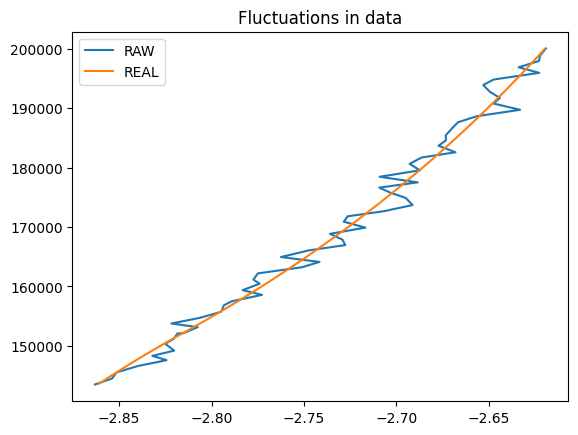

In [5]:
plt.plot(azimuth_raw[:60], range_raw[:60], label='RAW')
plt.plot(azimuth_real[:60], range_real[:60], label='REAL')
plt.legend()
plt.title('Fluctuations in data')
plt.show()

Mọi người có thể nhìn thấy trong hình trên, dữ liệu gốc thu về có sự biến động so với dữ liệu thực tế. Đây là do ảnh hưởng trong quá trình thu nhận dữ liệu, ảnh hưởng khách quan từ yếu tô môi trường. 

Vậy nên trước khi lấy dữ liệu để tính toán, ta cần một bước để xử lý các yếu tố nhiễu này trong dữ liệu.

#### Simple Moving Average 

Thuật toán SMA (Simple Moving Average) sẽ tính giá trị trung bình cho một tập giá trị biết trước. Trong bài toán của chúng ta là tính trung bình của n ngày trước đó

$SMA = \frac{A_1 + A_2 + ... + A_n}{n}$  
Trong đó:  
A: Trung bình của n giá trị trước đó  
n: Số lượng thời gian trước đó.

5 5


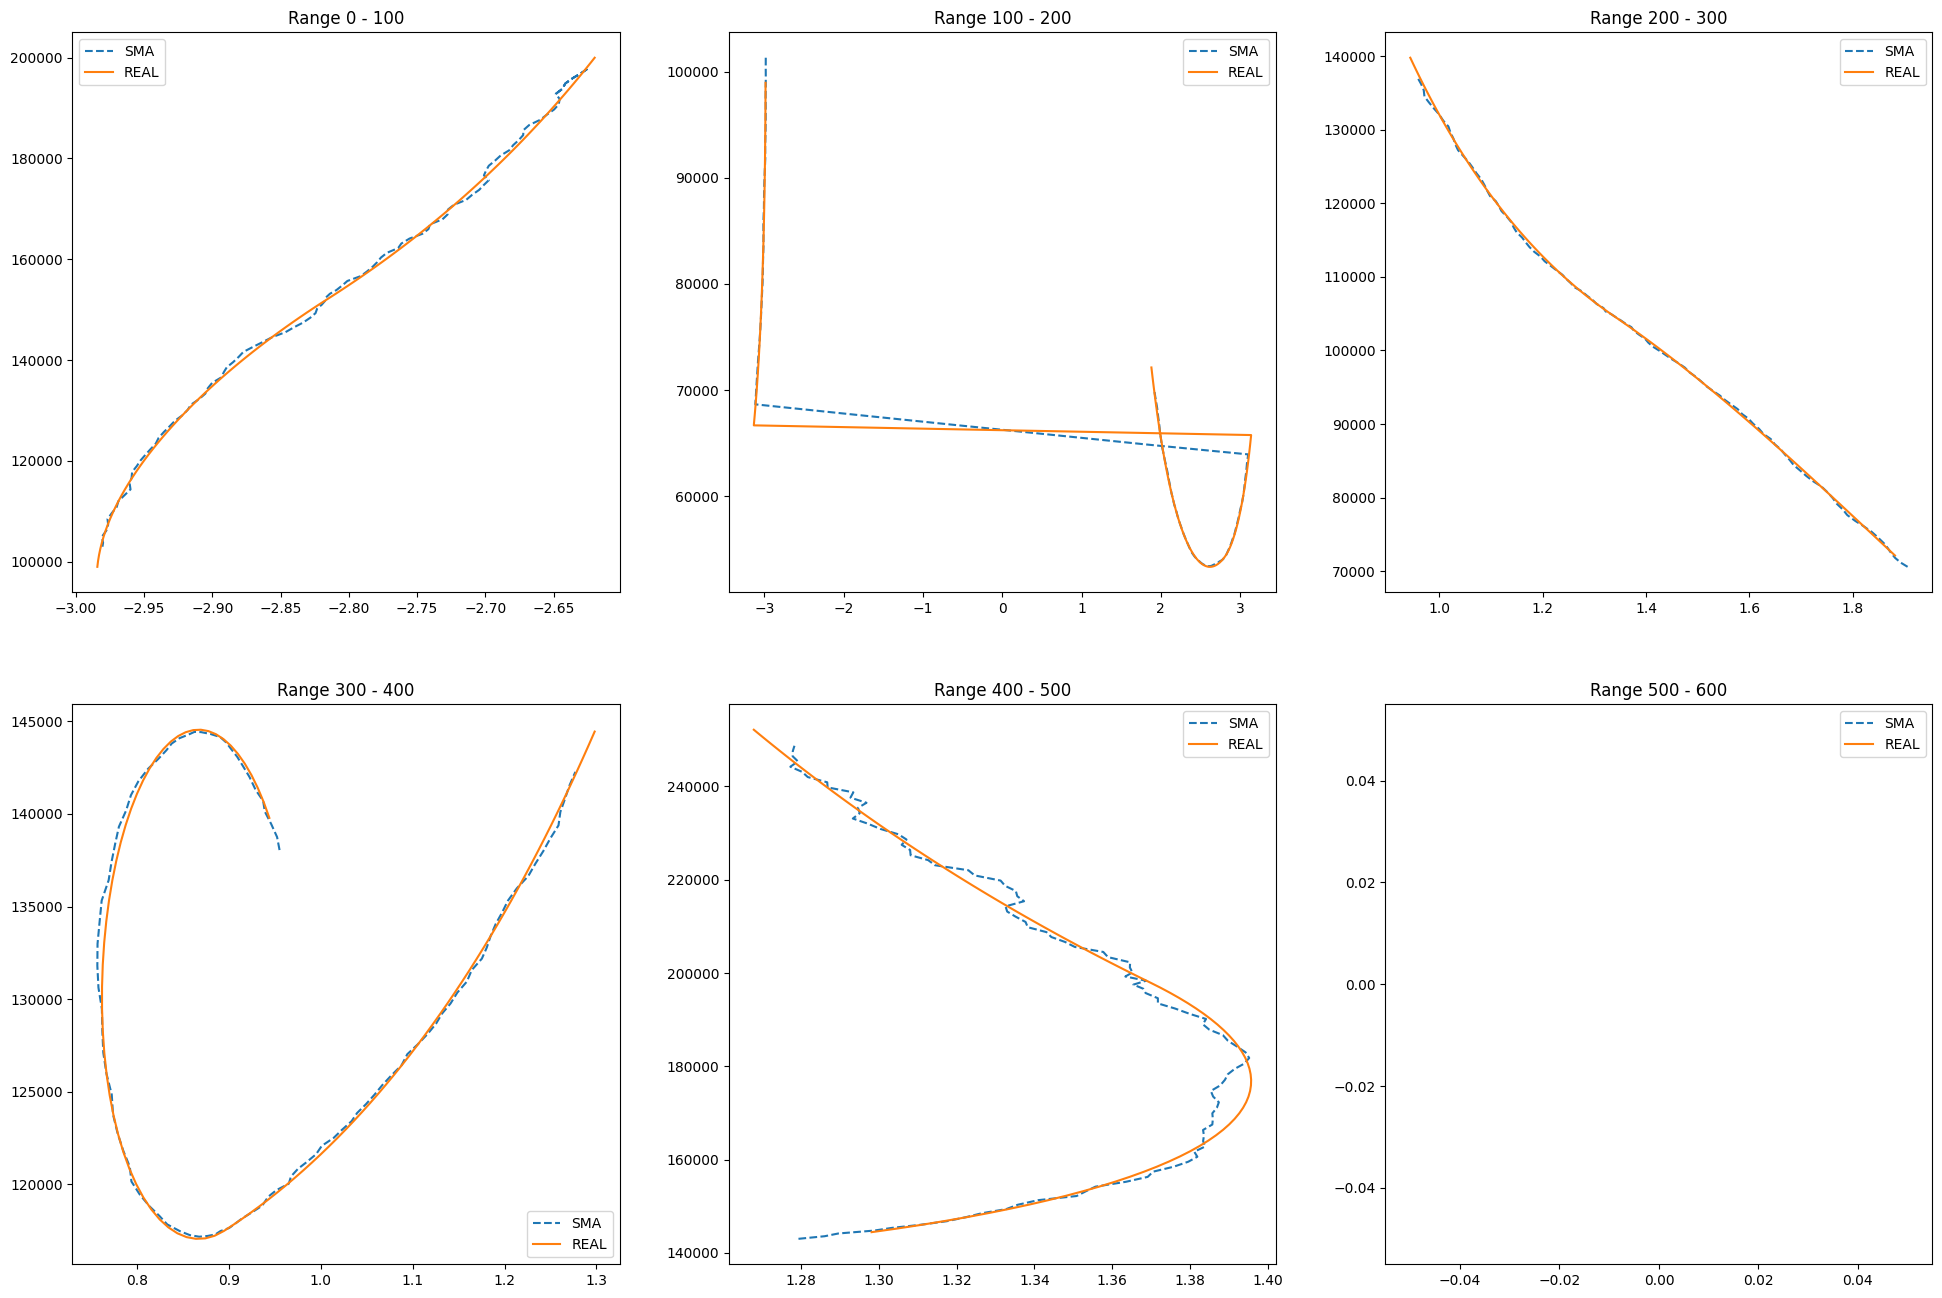

In [6]:
# Tìm kích thước cửa sổ phù hợp nhất
# m, ema_azimuth = find_best_window(azimuth_raw, azimuth_real)
# n, ema_range = find_best_window(range_raw, range_real)
m = 5
n = 5
print(m, n)
# n_window = 2
# Sử dụng module SMA để xử lý dữ liệu nhiễu

# Tính trung bình phương vị
sma_azimuth = simple_moving_average(azimuth_raw, m)
sma_azimuth = np.nan_to_num(sma_azimuth, 0)
# Tính trung bình khoảng cách
sma_range = simple_moving_average(range_raw, n)
sma_range = np.nan_to_num(sma_range, 0)

# Do dữ liệu khi tính trung bình sẽ mất n giá trị đầu, nên ta sẽ lật ngược tập dữ liệu để tính
# Sau đó điền các giá trị bị thiếu bằng giá trị trung bình ngược

# Tính giá trị trung bình phương vị ngược
sma_azimuth_revert = simple_moving_average(np.flip(azimuth_raw, axis=0), m)
sma_azimuth_revert = np.nan_to_num(sma_azimuth_revert, 0)
sma_azimuth[:m] = sma_azimuth_revert[-m:] + sma_azimuth[:m]

# Tính giá trị trung bình khoảng cách ngược
sma_range_revert = simple_moving_average(np.flip(range_raw, axis=0), n)
sma_range_revert = np.nan_to_num(sma_range_revert, 0)
sma_range[:n] = sma_range_revert[-n:] + sma_range[:n]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

counter = 0
for j in range(2):
    for k in range(3):
            if counter > 5:
                  break
            k_start = counter * 100
            k_end = (counter+1) * 100
            # Hiển thị đồ thị
            axs[j][k].plot(sma_azimuth[k_start:k_end], sma_range[k_start:k_end], linestyle='--', label='SMA')
            axs[j][k].plot(azimuth_real[k_start:k_end], range_real[k_start:k_end], label='REAL')
            axs[j][k].set_title(f'Range {k_start} - {k_end}')
            axs[j][k].legend()
            counter += 1
plt.show()


In [7]:
# Hiển thị giá trị min - max của tập ước lượng và tập thực
print("Evaluated:")
print('min:',np.min(sma_range), ', max:', np.max(sma_range))
print("Real:")
print('min:',np.min(range_real), ',max:', np.max(range_real))

Evaluated:
min: 53405.028868 , max: 248719.93723999997
Real:
min: 53350.50476 ,max: 252156.4507


In [8]:
# Compute the MSE

mse_range = mean_squared_error(range_real, sma_range)
mse_azimuth = mean_squared_error(azimuth_real, sma_azimuth)

print('MSE of range:', mse_range)
print('MSE of azimuth:', mse_azimuth)
print('----------------')
#Compute the RMSE

print('RMSE of range:', np.sqrt(mse_range))
print('RMSE of azimuth:', np.sqrt(mse_azimuth))

print('-' * 20)
print('MAE of range:', mae_range)
print('MAE of azimuth', mae_azimuth)

MSE of range: 6699849.109127226
MSE of azimuth: 0.17188016162168693
----------------
RMSE of range: 2588.4066738299116
RMSE of azimuth: 0.4145843238976685
--------------------
MAE of range: 78.73473837999992
MAE of azimuth 0.006780912856000002


In [9]:
# Compute the MSE

r2_range = r2_score(range_real, sma_range)
r2_azimuth = r2_score(azimuth_real, sma_azimuth)

print('r2 of range:', r2_range)
print('r2 of azimuth:', r2_azimuth)
print('----------------')

r2 of range: 0.9972386241277404
r2 of azimuth: 0.9554598923695743
----------------


Sau khi dùng kỹ thuật SMA để xử lý dữ liệu RAW, ta thấy rõ sự thay đổi của dữ liệu. Sữ liệu sau khi được xử lý đã sát hơn với dữ liệu thực tế.

In [10]:
#### Weighted Moving Average

#### Weighted Moving Average

Kỹ thuật WMA (Weighted Moving Average) sẽ gán thêm trọng số vào các điểm dữ liệu trong quá khứ, sau đó tính tổng tập dữ liệu đó.  
  
$WMA = Value_1 * w_1 + Value_2 * w_2 + ... Value_n*w_n$  
  
Trong đó:  
N là thời gian trước đó  

Chú ý: Trọng số được gán cho dữ liệu được tính bằng: $w_i = \frac{i}{\sum_{i=1}^n i}$, với i là ngày thứ mấy trong tập ngày được chọn. (i = 1, 2,..., n)

n_window = 5


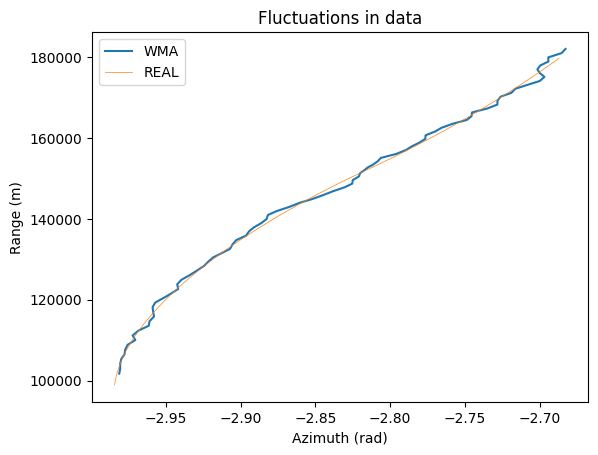

In [11]:
# Sử dụng module wma để xử lý dữ liệu nhiễu
# n_window = find_best_window(azimuth_raw, range_raw, azimuth_real, range_real, f_type='wma')
n_window= 5
print('n_window =',n_window)
# Tính trung bình xuôi
wma_azimuth = weighted_moving_average(azimuth_raw, n_window)
wma_azimuth = np.nan_to_num(wma_azimuth, 0)
wma_range = weighted_moving_average(range_raw, n_window)
wma_range = np.nan_to_num(wma_range, 0)

#Tính trung bình ngược
wma_azimuth_inverse = weighted_moving_average(np.flip(azimuth_raw, axis = 0), n_window)
wma_azimuth_inverse = np.nan_to_num(wma_azimuth_inverse, 0)
wma_range_inverse = weighted_moving_average(np.flip(range_raw,axis=0), n_window)
wma_range_inverse = np.nan_to_num(wma_range_inverse, 0)

#
wma_azimuth[:n_window] = wma_azimuth_inverse[-n_window:] + wma_azimuth[:n_window]
wma_range[:n_window] = wma_range_inverse[-n_window:] + wma_range[:n_window]
plt.plot(wma_azimuth[20:100], wma_range[20:100], label='WMA')
plt.plot(azimuth_real[20:100], range_real[20:100], label='REAL', lw=0.5)
plt.ylabel('Range (m)')
plt.xlabel('Azimuth (rad)')
plt.legend()
plt.title('Fluctuations in data')
plt.show()

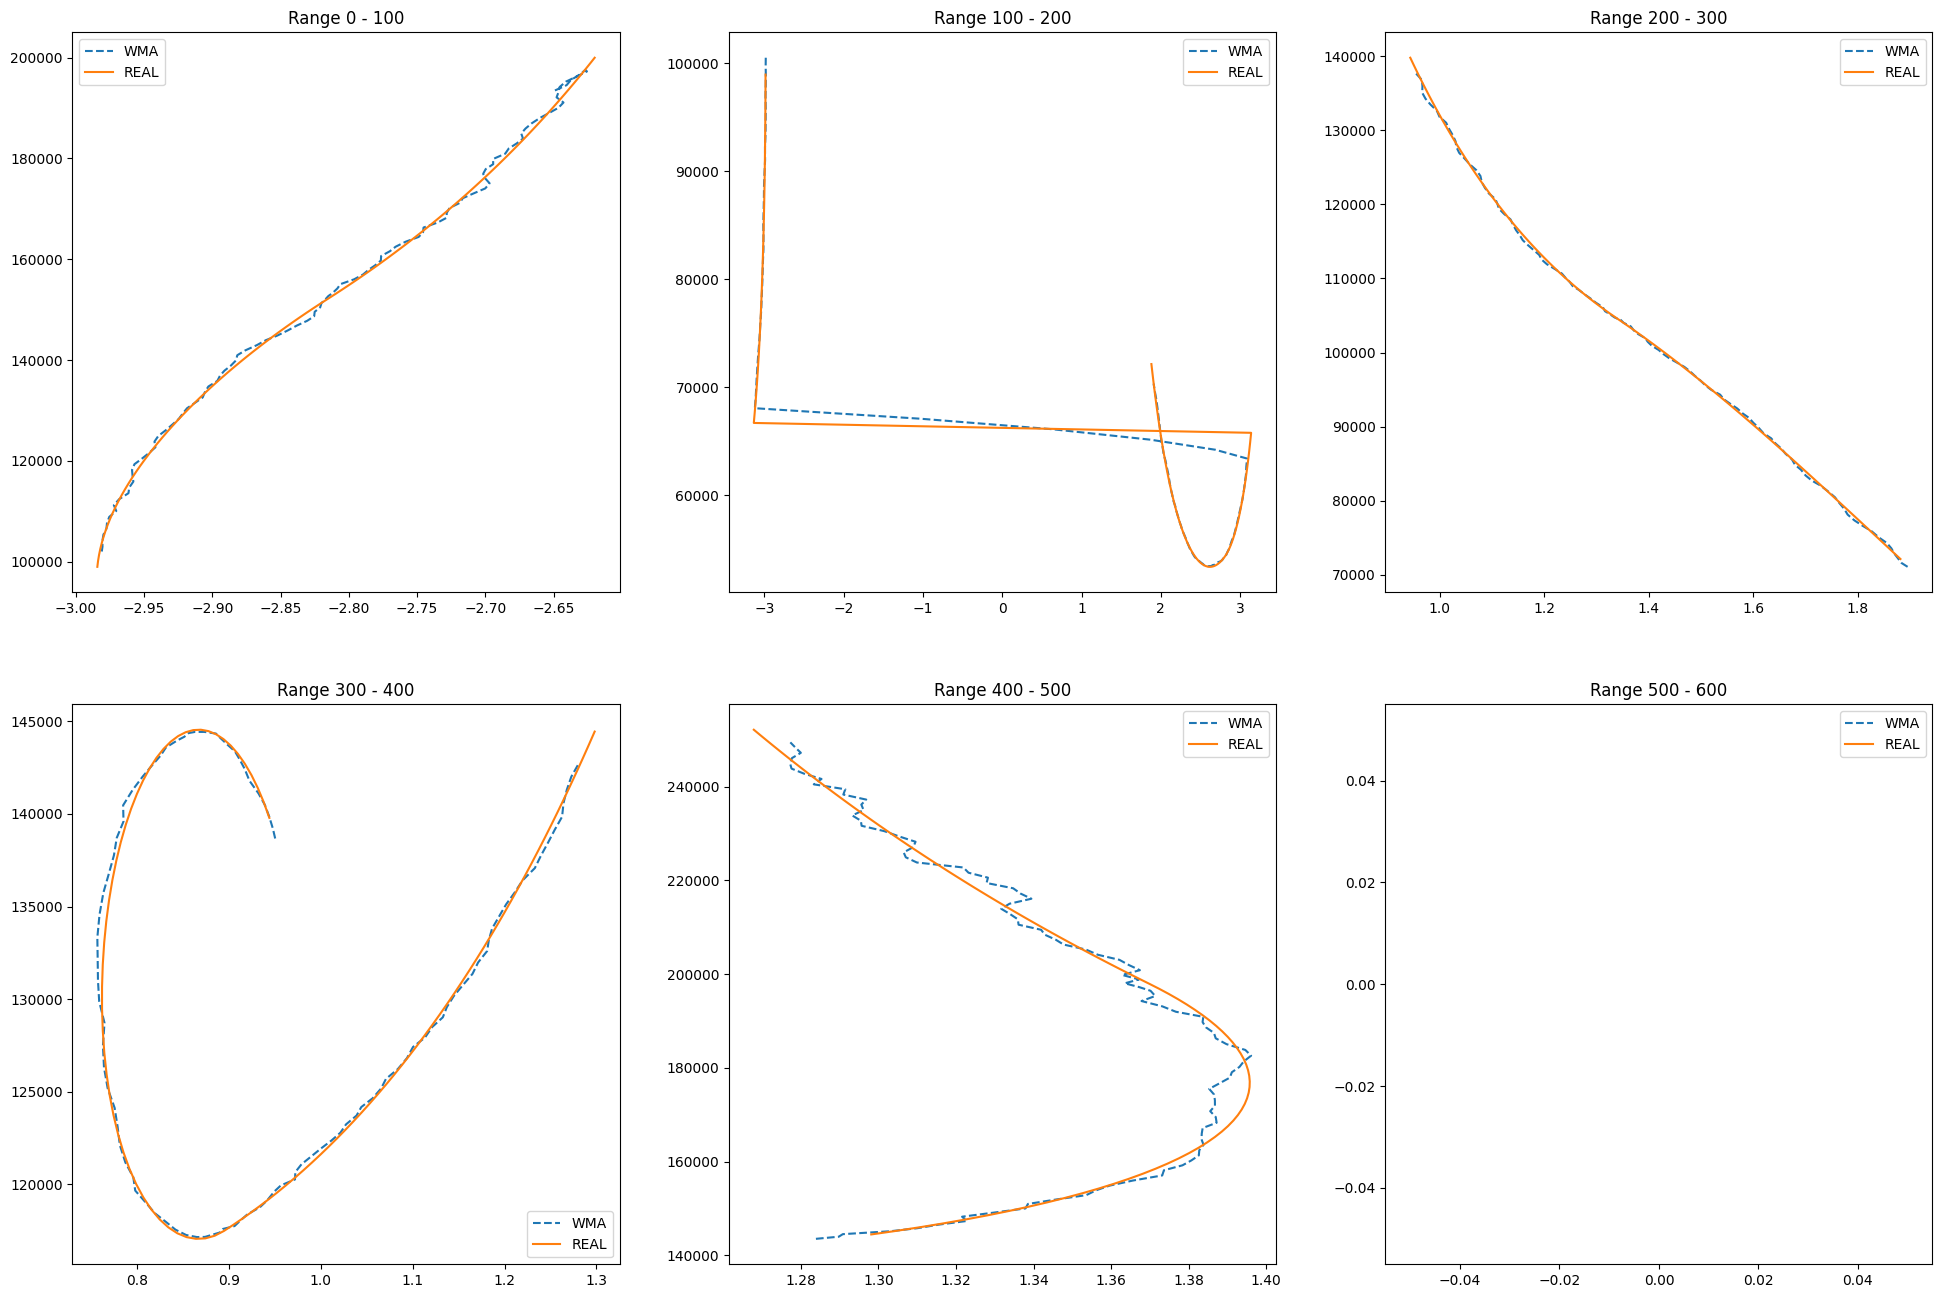

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

counter = 0
for j in range(2):
    for k in range(3):
            if counter > 5:
                  break
            k_start = counter * 100
            k_end = (counter+1) * 100
            # Hiển thị đồ thị
            axs[j][k].plot(wma_azimuth[k_start:k_end], wma_range[k_start:k_end], linestyle='--', label='WMA')
            axs[j][k].plot(azimuth_real[k_start:k_end], range_real[k_start:k_end], label='REAL')
            axs[j][k].set_title(f'Range {k_start} - {k_end}')
            axs[j][k].legend()
            counter += 1
plt.show()

In [13]:
# Compute the MSE

mse_range = mean_squared_error(range_real, wma_range)
mse_azimuth = mean_squared_error(azimuth_real, wma_azimuth)

print('MSE of range:', mse_range)
print('MSE of azimuth:', mse_azimuth)
print('-' * 20)
#Compute the RMSE

print('RMSE of range:', np.sqrt(mse_range))
print('RMSE of azimuth:', np.sqrt(mse_azimuth))

# Compute the MAE
mae_range = mean_absolute_error(range_real, wma_range)
mae_azimuth = mean_absolute_error(azimuth_real, wma_azimuth)

print('-' * 20)
print('MAE of range:', mae_range)
print('MAE of azimuth', mae_azimuth)

MSE of range: 4092411.4039154095
MSE of azimuth: 0.129069617247131
--------------------
RMSE of range: 2022.9709350149867
RMSE of azimuth: 0.3592626020714249
--------------------
MAE of range: 1877.751071545334
MAE of azimuth 0.04546309121693335


#### Exponential Moving Average

Kỹ thuật EMA (Exponential Moving Average) cho trọng số vào các giá trị gần đây trong chuỗi thời gian để làm nó có thêm sự liên quan đến thông tin mới sau đó.   

Thì trước khi tính một EMA, ta cần tính một lượng giá trị SMA nhất định trước đó.  

Sau đó, ta sẽ nhân giá trị SMA đó với trọng số được gọi là "smoothing factor", tính bởi công thức:  

$sf = \frac{2}{d + 1}$  

Và cuối cùng, công thức tính tổng quát của EMA sẽ là:  

$EMA_t = (V_t * sf) + EMA_y * (1 -sf)$   

Trong đó:  
- $EMA_t$ = EMA hiện tại  
- $V_t$ = Giá trị thời điểm hiện tại  
- $EMA_y$ = EMA trước đó  
- d = Số thời gian trước đó
- sf = smoothing factor

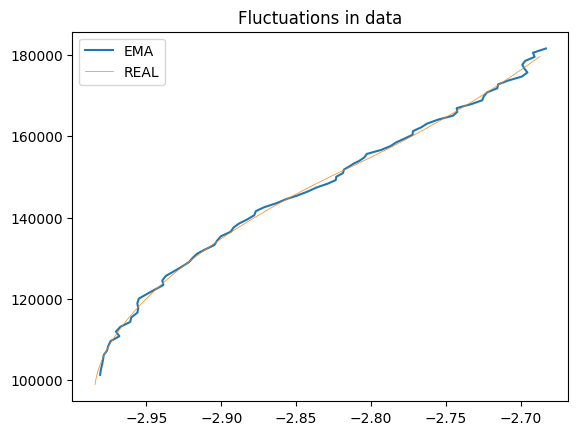

In [14]:
# Sử dụng module ema để xử lý dữ liệu nhiễu
n_window = 5

ema_azimuth = exponential_moving_average(azimuth_raw, n_window)
ema_range = exponential_moving_average(range_raw, n_window)
ema_azimuth = np.nan_to_num(ema_azimuth, 0)
ema_range = np.nan_to_num(ema_range, 0)
# Tính trung bình ngược
ema_azimuth_inverse = exponential_moving_average(np.flip(azimuth_raw, axis=0), n_window)
ema_range_inverse = exponential_moving_average(np.flip(range_raw, axis=0), n_window)
ema_azimuth_inverse = np.nan_to_num(ema_azimuth_inverse, 0)
ema_range_inverse = np.nan_to_num(ema_range_inverse, 0)
# Thay thế các giá trị bị khuyết tại ema
ema_azimuth[:n_window] = ema_azimuth[:n_window] + ema_azimuth_inverse[-n_window:]
ema_range[:n_window] = ema_range[:n_window] + ema_range_inverse[-n_window:]
plt.plot(ema_azimuth[20:100], ema_range[20:100], label='EMA')
plt.plot(azimuth_real[20:100], range_real[20:100], label='REAL', lw=0.5)
plt.legend()
plt.title('Fluctuations in data')
plt.show()

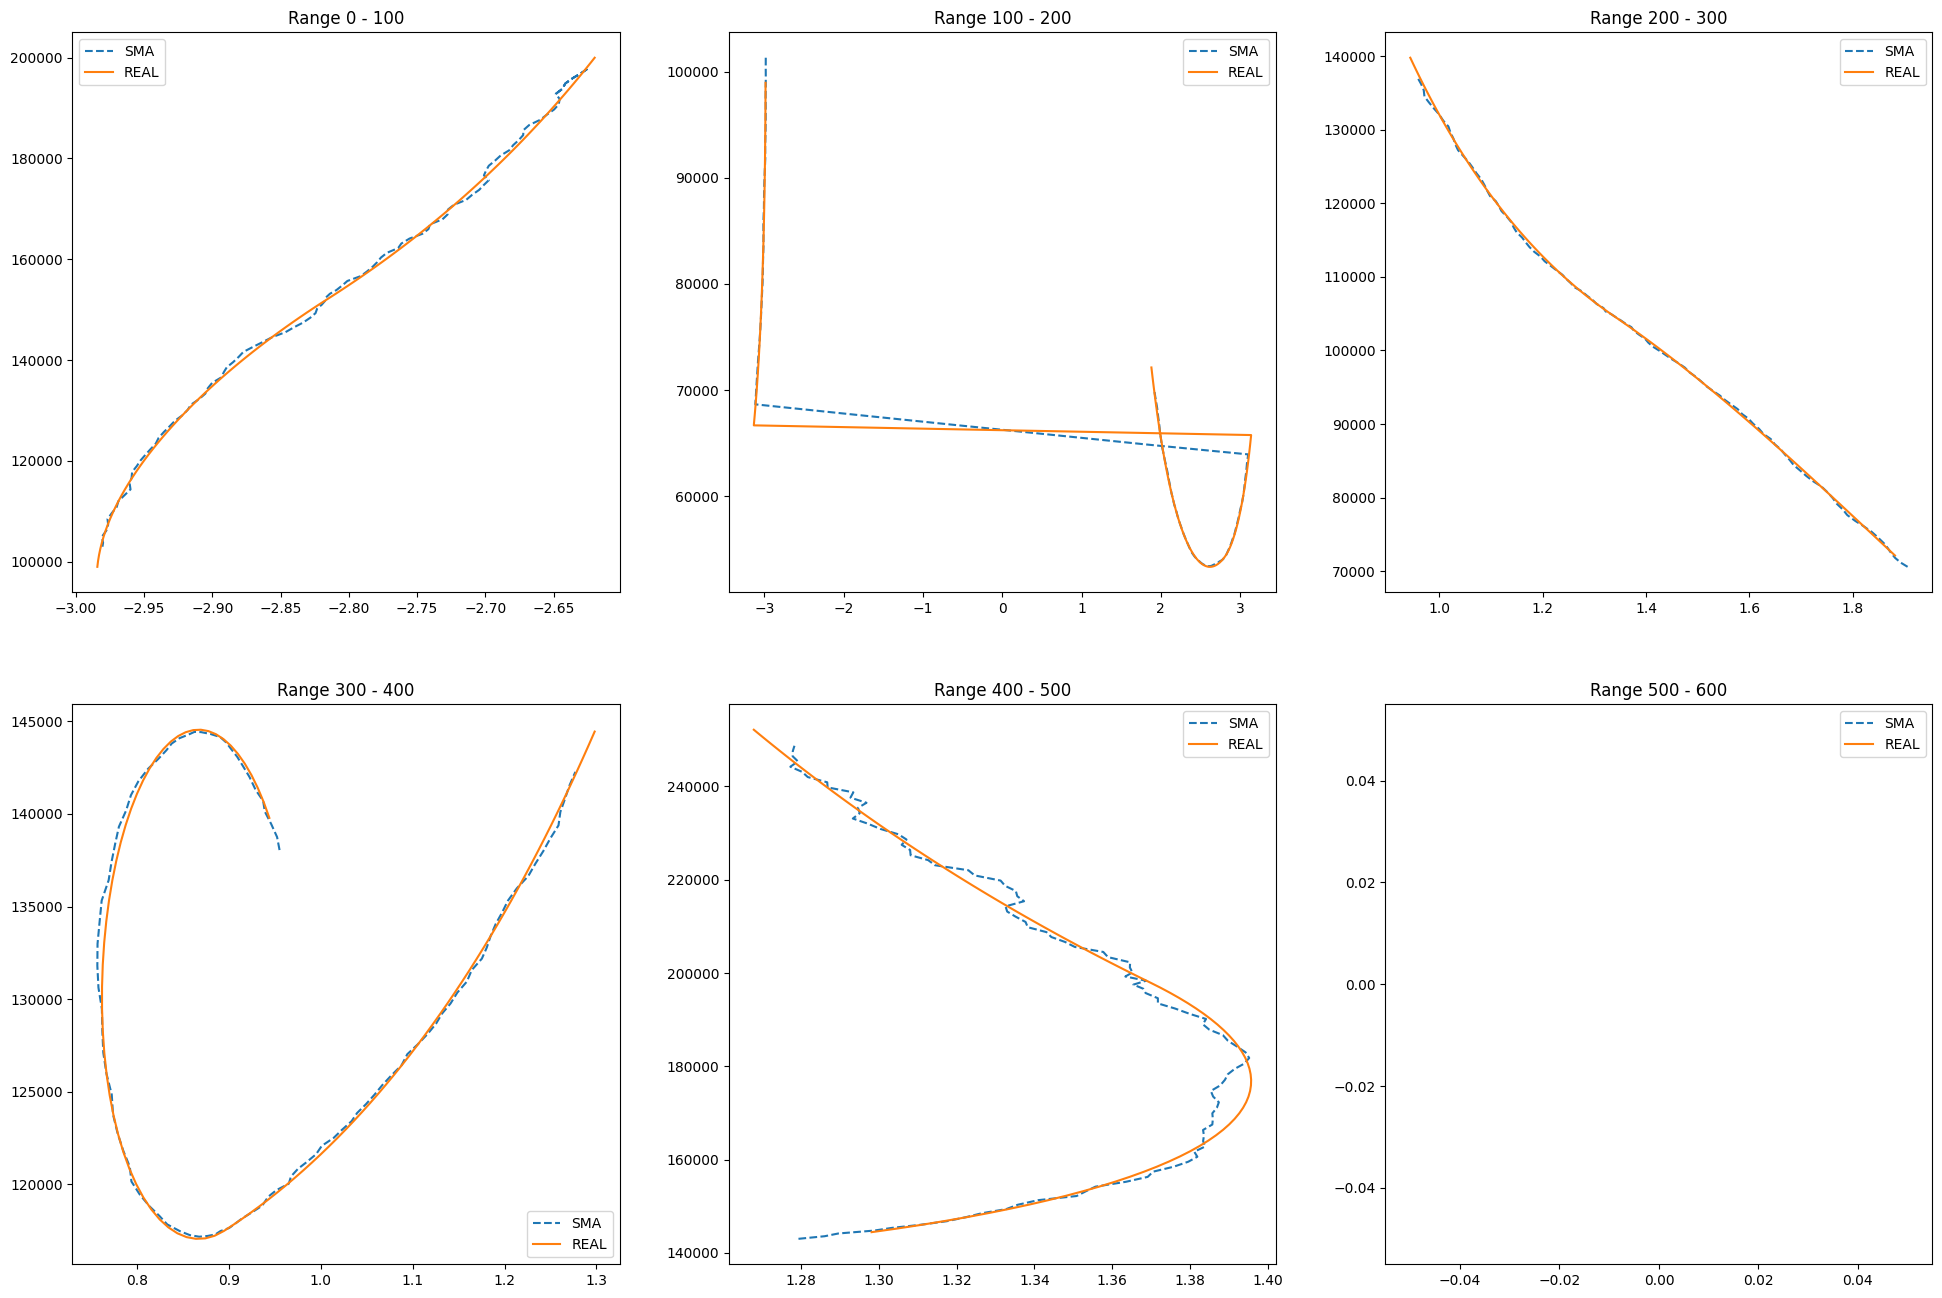

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

counter = 0
for j in range(2):
    for k in range(3):
            if counter > 5:
                  break
            k_start = counter * 100
            k_end = (counter+1) * 100
            # Hiển thị đồ thị
            axs[j][k].plot(sma_azimuth[k_start:k_end], sma_range[k_start:k_end], linestyle='--', label='SMA')
            axs[j][k].plot(azimuth_real[k_start:k_end], range_real[k_start:k_end], label='REAL')
            axs[j][k].set_title(f'Range {k_start} - {k_end}')
            axs[j][k].legend()
            counter += 1
plt.show()

In [16]:

# Compute the MSE

mse_range = mean_squared_error(range_real, ema_range)
mse_azimuth = mean_squared_error(azimuth_real, ema_azimuth)

print('MSE of range:', mse_range)
print('MSE of azimuth:', mse_azimuth)
print('-' * 20)
#Compute the RMSE

print('RMSE of range:', np.sqrt(mse_range))
print('RMSE of azimuth:', np.sqrt(mse_azimuth))

# Compute the MAE
mae_range = mean_absolute_error(range_real, wma_range)
mae_azimuth = mean_absolute_error(azimuth_real, wma_azimuth)

print('-' * 20)
print('MAE of range:', mae_range)
print('MAE of azimuth', mae_azimuth)

MSE of range: 3009530.7742048274
MSE of azimuth: 0.06246770870393421
--------------------
RMSE of range: 1734.799923393135
RMSE of azimuth: 0.24993540906389036
--------------------
MAE of range: 1877.751071545334
MAE of azimuth 0.04546309121693335


#### So sánh các kỹ thuật MA (Moving Average)

Sự khác nhau giữa SMA vs WMA:
- SMA chỉ đơn giản là tính trung bình của các điểm dữ liệu trong bộ, và trọng số được gán bằng nhau cho tất cả các quan sát của mẫu.  
- Trong khi đó, WMA sẽ gán một trọng số nhất định cho từng quan sát, với mỗi quan sát gần đây nhất sẽ được gán trọng số lớn hơn các quan sát trước đó. Việc này để thể hiện rõ sự tác động của các quan sát gần đây nhất với giá trị hiện tại


Sự khác nhau giữa SMA và EMA:  
- SMA tương đối chậm trong phản ứng vì nó tính toán trung bình của các giá trị trong một khoảng thời gian dài hơn, và không nhấn mạnh các giá trị gần đây.  
- Trong khi đó EMA phản ứng nhanh với sự thay đổi trong dữ liệu, vì các giá trị gần đây được đánh giá cao hơn trong quá trình tính toán từ đó ảnh hưởng đến kết quả. 

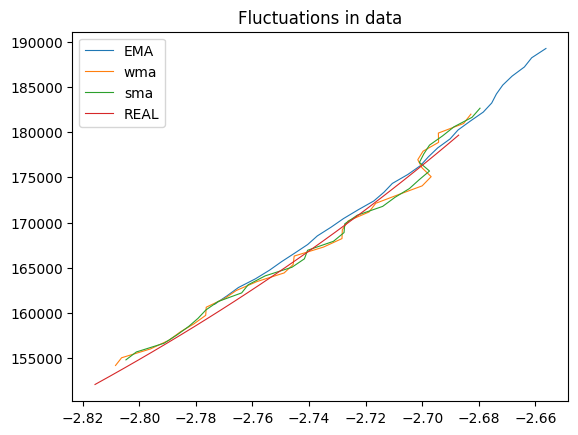

In [18]:
# Sử dụng module ema để xử lý dữ liệu nhiễu
n_window = 20
range_n = 50
ema_azimuth = exponential_moving_average(azimuth_raw, n_window)
ema_range = exponential_moving_average(range_raw, n_window)
plt.plot(ema_azimuth[20:range_n], ema_range[20:range_n], label='EMA', lw=0.8)
plt.plot(wma_azimuth[20:range_n], wma_range[20:range_n], label='wma', lw=0.8)
plt.plot(sma_azimuth[20:range_n], sma_range[20:range_n], label='sma', lw=0.8)
plt.plot(azimuth_real[20:range_n], range_real[20:range_n], label='REAL', lw=0.8)
plt.legend()
plt.title('Fluctuations in data')
plt.show()